In [1]:
import os
import torch
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
import torchvision.models as models
from torchsummary import summary
from PIL import Image
import torchvision.transforms as transforms
from vgg import VGG16

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.vgg16(pretrained=True).to(device).eval()
model = VGG16().to(device).eval()
print(model)

VGG16(
  (block1_conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block1_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block1_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2_conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block2_conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block2_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block3_conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block3_conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block3_conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block3_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block4_conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block4_conv2): Conv2d(512, 512, 

In [3]:
model_path = '/home/bitt/.torch/models/vgg16-397923af.pth'
original_name = list(torch.load(model_path).keys())

In [4]:
model_dict = torch.load(model_path)

In [5]:
print(type(model_dict))

<class 'collections.OrderedDict'>


In [6]:
names = []
for name, _ in model.named_parameters():
    names.append(name)
names
map_dict = dict(zip(original_name, names))

In [7]:
new_model_dict = {map_dict[k]: v for k, v in model_dict.items()}

In [8]:
model.load_state_dict(new_model_dict)

In [9]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]          36,928
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
            Conv2d-5        [-1, 128, 112, 112]         147,584
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
            Conv2d-8          [-1, 256, 56, 56]         590,080
            Conv2d-9          [-1, 256, 56, 56]         590,080
        MaxPool2d-10          [-1, 256, 28, 28]               0
           Conv2d-11          [-1, 512, 28, 28]       1,180,160
           Conv2d-12          [-1, 512, 28, 28]       2,359,808
           Conv2d-13          [-1, 512, 28, 28]       2,359,808
        MaxPool2d-14          [-1, 512,

In [78]:
# img_path = './2.jpg'
# img_path = './data/cats_and_dogs_small/test/cats/cat.1700.jpg'
img_path = './4.JPEG'

In [79]:
img = Image.open(img_path).convert("RGB")

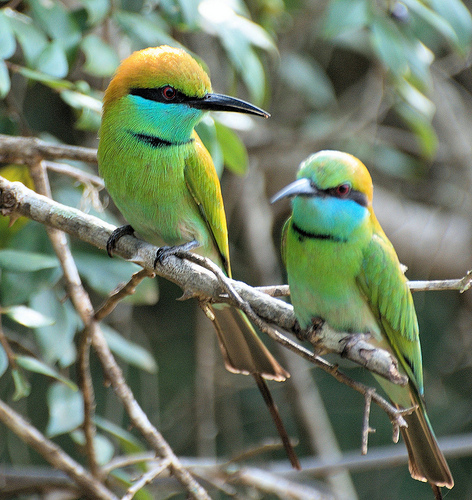

In [80]:
img

In [81]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


In [82]:
img = transform(img)

In [83]:
img = img.unsqueeze(0).to(device)
preds, block5_conv3, _ = model(img)

In [84]:
logits = torch.softmax(preds, dim=1)

In [85]:
print(logits.shape)

torch.Size([1, 1000])


In [86]:
torch.sum(logits)

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [87]:
torch.argmax(logits)

tensor(92, device='cuda:0')

In [88]:
index = torch.argmax(logits).item()

In [89]:
index

92

In [90]:
african_elephant_output = logits[:, index]

In [91]:
african_elephant_output

tensor([1.], device='cuda:0', grad_fn=<SelectBackward>)

In [92]:
print(block5_conv3.shape)

torch.Size([1, 512, 14, 14])


In [93]:
print(african_elephant_output.shape)

torch.Size([1])


In [94]:
# import torch.nn as nn
# criteria = nn.CrossEntropyLoss()

In [95]:
# loss = criteria(logits, torch.LongTensor([209]).to(device))

In [96]:
# loss

In [97]:
african_elephant_output

tensor([1.], device='cuda:0', grad_fn=<SelectBackward>)

In [98]:
print(block5_conv3.grad)
print(block5_conv3.requires_grad)

None
True


In [99]:
grads = torch.autograd.grad(african_elephant_output, block5_conv3, retain_graph=True)  # 再进行第二次求导报错

In [100]:
print(grads[0].shape)

torch.Size([1, 512, 14, 14])


In [101]:
gradients = grads[0]

In [102]:
pooled_grads = torch.mean(gradients, dim=(0, 3, 2))

In [103]:
pooled_grads[0]

tensor(-9.0074e-13, device='cuda:0')

In [104]:
print(pooled_grads.shape)

torch.Size([512])


In [105]:
import numpy as np
conv_layer_output_value = block5_conv3.data.squeeze(0).cpu().numpy()
print(conv_layer_output_value.shape)  # 类似与注意力机制
pooled_grads_value = pooled_grads.cpu().numpy()
print(pooled_grads_value.shape)
for i in range(512):
    conv_layer_output_value[i, :, :] *= pooled_grads_value[i]
conv_layer_output_value = np.abs(conv_layer_output_value)
heatmap = np.mean(conv_layer_output_value, axis=0)

(512, 14, 14)
(512,)


In [106]:
print(heatmap.shape)

(14, 14)


In [107]:
import matplotlib.pyplot as plt
heatmap = abs(heatmap)
heatmap /= np.max(heatmap)

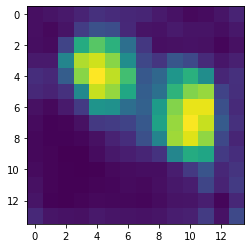

In [108]:
plt.imshow(heatmap)

In [109]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

In [110]:
cv2.imwrite('img1.jpg', superimposed_img)

True

In [111]:
from PIL import Image
img = Image.open('img1.jpg')

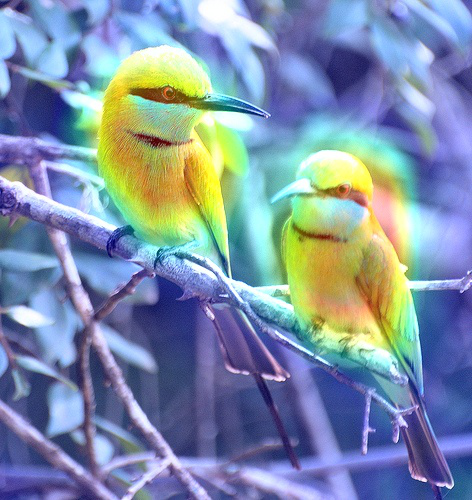

In [112]:
img